### __init__ - start up all the modules we need and connect to the database

In [8]:
import pandas as pd
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
import pymongo
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import re
from sklearn.metrics.pairwise import cosine_similarity
import pickle


%matplotlib inline
from pymongo import MongoClient

client = pymongo.MongoClient('34.210.38.96', 27016)
db_ref = client['wikipedia']

### Extract Transform Load - define functions to query wiki for all the pages in a specific category/subcategory, save the text of a given page, and load the resulting data into mongo

In [ ]:
# a function to pull out all the named pages in a category/subcategory chain, to a specified depth
def wiki_save_cats(cmtitle, tree_depth):
    url_base = "https://en.wikipedia.org/w/api.php"
    params = {
    "action": 'query',
    "format": 'json',
    "list": 'categorymembers',
    "cmtitle": cmtitle,
    "cmlimit": 'max'
    }

    outputs = []
    page_title_list = []
    pages_id_list    = []
    
    response = requests.get(url_base, params = params)
    json_response = response.json()
    
    pages = list(filter(lambda x: x['ns'] == 0, json_response['query']['categorymembers']))
    subcats = list(filter(lambda x: x['ns'] == 14, json_response['query']['categorymembers']))

    for i in range(len(pages)):
        this_page = pages[i]['title'].replace(' ','_')
        page_title_list.append(this_page)
        pages_id_list.append(pages[i]['pageid'])
    
    zipped = list(zip(pages_id_list, page_title_list))
    outputs.extend(zipped)

    if (len(subcats) > 0) and (tree_depth > 0):
        tree_depth -= 1
        for i in range(len(subcats)):
            new_category = subcats[i]['title'].replace(' ','_')
            outputs.extend(wiki_save_cats(new_category, tree_depth))
        return outputs
    else:
        return outputs
    
# a function to extract the text from a given page
def wiki_save_page(page_title):
    url_base = "https://en.wikipedia.org/w/api.php"
    params = {
    "action": "query",
    "format": "json",
    "prop": "extracts",
    "titles": page_title,
    "exlimit": "max"
    }
    response = requests.get(url_base, params = params)
    json_response = response.json()
    return json_response

In [ ]:
# a function combining the above with some cleaning, followed by uploading to mongo
def extract_transform_load(category, tree_depth):
    
    # generate our total list of pages in this category
    list_of_cats = wiki_save_cats(category, tree_depth) 
    
    # create (or specify) a new collection for this category
    coll_ref = db_ref[category] 
    
    # loop over each pageid/page name to save the whole html, extract the human text
    for page_tuple in tqdm(list_of_cats): 
        page_text = wiki_save_page(page_tuple[1]) 
        text_extract = page_text['query']['pages'][str(page_tuple[0])]['extract']
        soup = BeautifulSoup(text_extract, 'html.parser')
        
        # and insert it into a mongo doc as a dict with pageid and text_extract as keys
        coll_ref.insert_one({
            'pageid':str(page_tuple[0]),
            'text_extract':soup.get_text()
        }) 

In [7]:
# two music genres were chosen because of their overlap in terms with machine learning

# extract_transform_load('Category:Machine_learning', 100)
# extract_transform_load('Category:Business_software', 2)
# extract_transform_load('Category:Heavy_metal_genres', 2)
# extract_transform_load('Category:Electronic_music_genres', 2)

# db_ref.drop_collection('Category:Electronic_music_genres')
# db_ref.drop_collection('Category:Heavy_metal_genres')
# db_ref.drop_collection('Category:Machine_learning')
# db_ref.drop_collection('Category:Business_software')

# wiki.drop_database('<DBNAME>')

# client.database_names(), db_ref.collection_names(), coll_ref.find_one()

### pull data back in to python for manipulation

In [ ]:
list_of_cats = [
                'Category:Machine_learning',
                'Category:Business_software',
                'Category:Heavy_metal_genres', 
                'Category:Electronic_music_genres'
]

# some additional regex cleaning
def cleaner(text):
    TAG_RE = re.compile(r'<[^>]+>')
    text = TAG_RE.sub('', text)
    text = re.sub('\n', '', text)              
    return(text)

# go through cat list, pull those databases, concat, clean, dedupe
def mongo_pull_clean(list_of_cats): 
    mongo_fields = ['pageid','text_extract']
    corpus_df = pd.DataFrame()
    for cat in list_of_cats:
        cursor = db_ref[cat].find()
        cat_df = pd.DataFrame(list(cursor), columns = mongo_fields)
        corpus_df = pd.concat([corpus_df, cat_df])
    corpus_df['text_extract'] = corpus_df['text_extract'].apply(cleaner)
    return corpus_df.drop_duplicates(subset=['pageid', 'text_extract'], keep='first')

In [ ]:
corpus_df = mongo_pull_clean(list_of_cats)
pickle.dump(corpus_df, open('corpus_df', "wb" ) )

corpus_df.shape

### fit model for Semantic Search - a few rounds of experimentation lead me to 0.01 as a good value for min_df in order to reduce the dimensionality of the pre-SVD DTM

In [11]:
tfidf_vectorizer = TfidfVectorizer(min_df = 0.01, strip_accents='unicode', stop_words = 'english')
document_term_matrix_sps = tfidf_vectorizer.fit_transform(corpus_df.text_extract)
document_term_matrix_df = pd.DataFrame(document_term_matrix_sps.toarray(),
                                       index=corpus_df.text_extract,
                                       columns=tfidf_vectorizer.get_feature_names())
document_term_matrix_df.shape

(10380, 4329)

In [9]:
document_term_matrix_df.sample(5)

released
text_extract                                                
Vista Chino is an American rock band, formed in...       1.0
DJ S.K.T is a British underground music produce...       1.0
Tiësto's Club Life is Dutch DJ Tiësto's weekly ...       1.0
The Greatest Video Game Music, performed by the...       1.0
Infestdead Records is an independent record lab...       1.0

In [7]:
n_components = 500
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]
svd_matrix = SVD.fit_transform(document_term_matrix_df)
sum(SVD.explained_variance_ratio_)

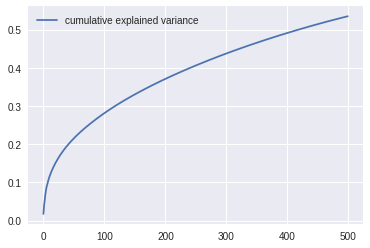

In [10]:
plt.plot(range(500), np.cumsum(SVD.explained_variance_ratio_), label='cumulative explained variance')
plt.legend()

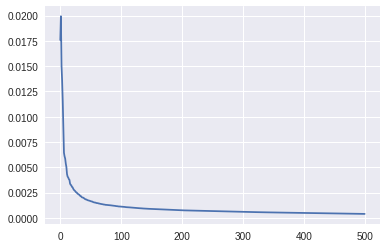

In [11]:
### Scree Plot

plt.plot(SVD.explained_variance_ratio_)

In [ ]:
pickle.dump(svd_matrix, open('svd_matrix', "wb" ) )
pickle.dump(tfidf_vectorizer, open('tfidf_vectorizer', "wb" ) )
pickle.dump(SVD, open('SVD', "wb" ) )

### search component

In [9]:
# load the saved models
svd_matrix = pickle.load( open( "svd_matrix", "rb" ) ) 
tfidf_vectorizer = pickle.load( open( "tfidf_vectorizer", "rb" ) )
SVD = pickle.load( open( "SVD", "rb" ) )
corpus_df = pickle.load( open( "corpus_df", "rb" ) )

# a function to return a wiki url from the pageid
def wiki_linkify(page_index):
    return "http://en.wikipedia.org/?curid={}".format(corpus_df.iloc[page_index]['pageid'])

# a function to return the text_extract from a saved page in mongo
def wiki_textify(page_index):    
    return corpus_df.iloc[page_index]['text_extract']

# given search terms and desired num_results, return the best answers!
def return_wiki_page_index(search_terms, num_results):
    search_terms_encoded = tfidf_vectorizer.transform([search_terms]) # encode the search
    svd_search = SVD.transform(search_terms_encoded) # transform the search
    svd_df = pd.DataFrame(svd_matrix) # df the results
    svd_df['cosine_sim'] = cosine_similarity(svd_df, svd_search) # add on the cos btwn df and search
    
    # pull most similar <num_results> pages and look up their associated wiki urls
    results_matrix = svd_df[['cosine_sim']].sort_values('cosine_sim', ascending=False).head(num_results) 
    results_matrix['wikipedia link'] = results_matrix.index
    results_matrix['wikipedia link'] = results_matrix['wikipedia link'].apply(wiki_linkify)
    return results_matrix

## ...and the search!

In [5]:
search_terms = "office space"
return_wiki_page_index(search_terms,5)

,cosine_sim,wikipedia link
1961,0.690162,http://en.wikipedia.org/?curid=274976
3510,0.660983,http://en.wikipedia.org/?curid=28677733
1957,0.650366,http://en.wikipedia.org/?curid=4567532
3518,0.626597,http://en.wikipedia.org/?curid=20288
3533,0.618184,http://en.wikipedia.org/?curid=2199016


In [4]:
wiki_textify(3510)

'Feng Office is a Software Development Company known for developing Feng Office Collaboration Platform and associated services:Feng Sky  is Feng Office on Demand provided as SaaSFeng Onsite  is Feng Office platform installed in External ServersFeng Office Community Edition  is the Open Source self-installed and self supported versionHistoryFeng Office started as The OpenGoo Open Source Project, a degree project at the faculty of Engineering of the University of the Republic, Uruguay. The project was presented and championed by Software Engineer Conrado Viña. Software Engineers Marcos Saiz and Ignacio de Soto developed the first prototype as their thesis. Professors Eduardo Fernández and Tomás Laurenzo  served as tutors. Conrado, Ignacio and Marcos founded the OpenGoo community and remain active members and core developers. The thesis was approved with the highest score.In 2008, Conrado Viña, Marcos Saiz, Sergio Riestra and Ignacio de Soto started the company Feng Office taking care of 